### [CIFAR10 분류기]

- 기초 인공신경망을 통해서 사진 분류기를 학습함
- 데이터집합은 CIFAR-10이며, 아래의 예와 같이 10가지의 3(R, G, B)채널의 32*32 크기의 사진으로 구성됨
- CIFAR-10과 같이 많이 사용되는 데이터집합은 torchvision 패키지에서 제공함
- 분류기 학습은 다음과 같은 과정을 가짐
     1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함
     2. 컨볼루션 신경망을 정의함
     3. 손실함수 정의
     4. 훈련집합을 이용하여 신경망을 학습시킴
     5. 테스트집합을 이용하여 신경망 성능 확인


***
**1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재**

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 frog  ship plane horse


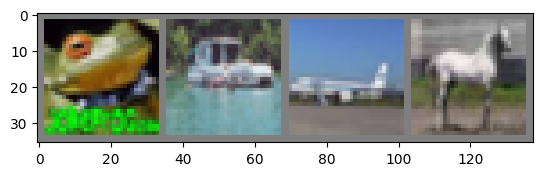

In [10]:
# functions to show an image
def imshow(img):
 img = img / 2 + 0.5 # unnormalize
 npimg = img.numpy()
 plt.imshow(np.transpose(npimg, (1, 2, 0)))
 
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

***
**2. conv신경망 정의**
- 3채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 클래스 분류를 수행

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
net = Net()

***
**3. 손실 함수 정의, Cross-Entropy & SGD+momentum**

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

***
**4. 훈련 집합을 이용하여 신경망을 학습시킴**

In [14]:
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
        running_loss = 0.0
        
print('Finished Training')

[1,  1000] loss: 0.002
[1,  2000] loss: 0.002
[1,  3000] loss: 0.002
[1,  4000] loss: 0.002
[1,  5000] loss: 0.001
[1,  6000] loss: 0.002
[1,  7000] loss: 0.002
[1,  8000] loss: 0.002
[1,  9000] loss: 0.002
[1, 10000] loss: 0.001
[1, 11000] loss: 0.002
[1, 12000] loss: 0.002
[2,  1000] loss: 0.002
[2,  2000] loss: 0.002
[2,  3000] loss: 0.001
[2,  4000] loss: 0.002
[2,  5000] loss: 0.001
[2,  6000] loss: 0.002
[2,  7000] loss: 0.002
[2,  8000] loss: 0.002
[2,  9000] loss: 0.002
[2, 10000] loss: 0.002
[2, 11000] loss: 0.002
[2, 12000] loss: 0.002
Finished Training


***
**5. 테스트 집합을 이용하여 신경망 성능 확인**

GroundTruth:    cat  ship  ship plane
Predicted:    car   car plane plane


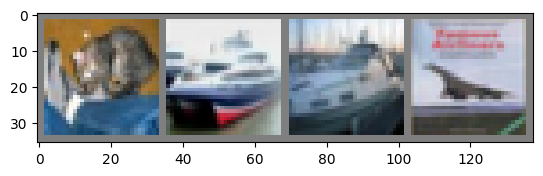

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [16]:
# performance on the whole test dataset
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 24 %


In [17]:
# performance on each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
for i in range(10):
 print('Accuracy of %5s : %2d %%' % (
 classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 60 %
Accuracy of  bird : 14 %
Accuracy of   cat : 15 %
Accuracy of  deer :  0 %
Accuracy of   dog :  8 %
Accuracy of  frog : 51 %
Accuracy of horse : 25 %
Accuracy of  ship :  3 %
Accuracy of truck :  5 %
